***
    
Demo EvoJAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving Linearized Burgers equation 
    
    2. Optimize PINN using xNES + NAG solver in the JAX framework
<!--        -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022). -->

# Demo

In [1]:
# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# import library
import numpy as np
import time

# import problem
from linear import get_fitness, policy # Number of parameters: 260

xNES +NAG Solver

In [2]:
from jax import random, numpy as jnp
from jax.scipy.linalg import expm
from jax import jit, vmap
seed = 1
def xNES_NAG(f, x0, bs=20, lr=1e-3, sigma=1, maxtime=60, momentum_coeff=0.9, verbose=False):
    
    """ [xNES_NAG]
    Implemented baseline algo.: Exponential NES (xNES) as described in Glasmachers, Schaul, Sun, Wierstra and Schmidhuber (GECCO'10).
    Maximizes a function f. Returns (best solution found, corresponding fitness, etc.).
    
    Added Nesterov Accelerated Gradient (NAG) 
    """
    # Initialize random generator (+ seed)
    
    key, rng = random.split(random.PRNGKey(seed))
    
    # target search
    center = x0.copy()
    dim = len(x0)
    I = jnp.eye(dim)
    A = I * sigma
    momentum = jnp.zeros(dim)
    bestFitness = -jnp.inf    
    learningRate = lr     # a same learning rate apply to all updates (including mixture model coef.)
    batchSize = bs    
    bestFound = None
    bestFitness = -jnp.inf
    
    loss_ls = []
    t_training_ls = []
    
    @jit
    def project_sample(center, A, momentum, rng):
        center_proj = center + momentum_coeff * momentum
        # produce and evaluate samples
        key, rng = random.split(rng) # update random generator
        samples = random.normal(key, [batchSize, dim])
        samples_o = jnp.dot(samples, A) + center_proj
        return (samples, samples_o, rng)

    @jit
    def computeUtilities(fitnesses):
        l = jnp.argsort(fitnesses)
        ranks = jnp.argsort(l)
        L = fitnesses.size
        # smooth reshaping
        utilities = jnp.array([jnp.maximum(0., x) for x in jnp.log(L / 2. + 1.0) - jnp.log(L - jnp.array(ranks))])
        utilities /= sum(utilities)       # make the utilities sum to 1
        utilities -= 1. / L  # baseline
        return utilities

    @jit
    def update_parameters(center, A, momentum, utilities, samples):    
        # NAG parameter updates
        update_center = jnp.dot(A, jnp.dot(utilities, samples)) + momentum_coeff * momentum
        momentum = update_center
        # update center and variances
        center += update_center   
        covGradient = sum([u * (jnp.outer(s, s) - I) for (s, u) in zip(samples, utilities)])
        A = jnp.dot(A, expm(0.5 * learningRate * covGradient))
        return (center, A, momentum)
  
    
    # loop
    numEvals = 0
    t_training = 0
    while t_training <= maxtime:
        start = time.time()
        # do partial update (project into new center) & produce samples
        samples, samples_o, rng = project_sample(center, A, momentum, rng)        
        # evaluate sample fitness
        fitnesses = f(samples_o)
        # return best fitness and solution
        if max(fitnesses) > bestFitness:
            _bestFitness = jnp.argmax(fitnesses)
            bestFitness, bestFound = fitnesses[_bestFitness], samples_o[_bestFitness]
        # update no. evaluations 
        numEvals += batchSize
        # print progress
        if verbose:
            print ("Step %5d | lr %.1e | numEvals %7d  : %.3e   [Best: %.5e]" %(numEvals/batchSize, lr, numEvals,
                                                                                max(fitnesses), bestFitness))        
        
        # fitness shaping
        utilities = computeUtilities(fitnesses)
        # parameter updates
        center, A, momentum = update_parameters(center, A, momentum, utilities, samples)
        end = time.time()
        t_training += (end-start)
        
        t_training_ls.append(t_training)
        loss_ls.append(bestFitness)
        
    print("...\nRunning time: %d secs!" %(t_training))
    print("\nNo of iterations: %d iterations!" %(numEvals/batchSize))
    return bestFound, bestFitness, numEvals, t_training_ls, loss_ls


Training

In [3]:
# optimize PINN (no source -> xNES)
w0 = jnp.zeros(policy.num_params)
op_weight, op_fitness, evals, t_training_ls, loss_ls = xNES_NAG(get_fitness, w0, bs=100, lr=0.01, sigma=0.001, momentum_coeff=0.9, verbose=True)

Step     1 | lr 1.0e-02 | numEvals     100  : -1.039e+01   [Best: -1.03902e+01]
Step     2 | lr 1.0e-02 | numEvals     200  : -1.039e+01   [Best: -1.03901e+01]
Step     3 | lr 1.0e-02 | numEvals     300  : -1.039e+01   [Best: -1.03901e+01]
Step     4 | lr 1.0e-02 | numEvals     400  : -1.039e+01   [Best: -1.03901e+01]
Step     5 | lr 1.0e-02 | numEvals     500  : -1.039e+01   [Best: -1.03899e+01]
Step     6 | lr 1.0e-02 | numEvals     600  : -1.039e+01   [Best: -1.03897e+01]
Step     7 | lr 1.0e-02 | numEvals     700  : -1.039e+01   [Best: -1.03893e+01]
Step     8 | lr 1.0e-02 | numEvals     800  : -1.039e+01   [Best: -1.03889e+01]
Step     9 | lr 1.0e-02 | numEvals     900  : -1.039e+01   [Best: -1.03882e+01]
Step    10 | lr 1.0e-02 | numEvals    1000  : -1.039e+01   [Best: -1.03872e+01]
Step    11 | lr 1.0e-02 | numEvals    1100  : -1.039e+01   [Best: -1.03859e+01]
Step    12 | lr 1.0e-02 | numEvals    1200  : -1.038e+01   [Best: -1.03844e+01]
Step    13 | lr 1.0e-02 | numEvals    13

Step   104 | lr 1.0e-02 | numEvals   10400  : -8.274e+00   [Best: -8.27354e+00]
Step   105 | lr 1.0e-02 | numEvals   10500  : -8.261e+00   [Best: -8.26145e+00]
Step   106 | lr 1.0e-02 | numEvals   10600  : -8.251e+00   [Best: -8.25132e+00]
Step   107 | lr 1.0e-02 | numEvals   10700  : -8.243e+00   [Best: -8.24298e+00]
Step   108 | lr 1.0e-02 | numEvals   10800  : -8.237e+00   [Best: -8.23676e+00]
Step   109 | lr 1.0e-02 | numEvals   10900  : -8.232e+00   [Best: -8.23234e+00]
Step   110 | lr 1.0e-02 | numEvals   11000  : -8.230e+00   [Best: -8.23044e+00]
Step   111 | lr 1.0e-02 | numEvals   11100  : -8.230e+00   [Best: -8.23000e+00]
Step   112 | lr 1.0e-02 | numEvals   11200  : -8.230e+00   [Best: -8.23000e+00]
Step   113 | lr 1.0e-02 | numEvals   11300  : -8.231e+00   [Best: -8.23000e+00]
Step   114 | lr 1.0e-02 | numEvals   11400  : -8.232e+00   [Best: -8.23000e+00]
Step   115 | lr 1.0e-02 | numEvals   11500  : -8.231e+00   [Best: -8.23000e+00]
Step   116 | lr 1.0e-02 | numEvals   116

Step   212 | lr 1.0e-02 | numEvals   21200  : -6.544e+00   [Best: -6.54357e+00]
Step   213 | lr 1.0e-02 | numEvals   21300  : -6.528e+00   [Best: -6.52780e+00]
Step   214 | lr 1.0e-02 | numEvals   21400  : -6.511e+00   [Best: -6.51135e+00]
Step   215 | lr 1.0e-02 | numEvals   21500  : -6.497e+00   [Best: -6.49746e+00]
Step   216 | lr 1.0e-02 | numEvals   21600  : -6.483e+00   [Best: -6.48259e+00]
Step   217 | lr 1.0e-02 | numEvals   21700  : -6.468e+00   [Best: -6.46841e+00]
Step   218 | lr 1.0e-02 | numEvals   21800  : -6.454e+00   [Best: -6.45403e+00]
Step   219 | lr 1.0e-02 | numEvals   21900  : -6.440e+00   [Best: -6.44008e+00]
Step   220 | lr 1.0e-02 | numEvals   22000  : -6.426e+00   [Best: -6.42600e+00]
Step   221 | lr 1.0e-02 | numEvals   22100  : -6.412e+00   [Best: -6.41200e+00]
Step   222 | lr 1.0e-02 | numEvals   22200  : -6.397e+00   [Best: -6.39724e+00]
Step   223 | lr 1.0e-02 | numEvals   22300  : -6.384e+00   [Best: -6.38404e+00]
Step   224 | lr 1.0e-02 | numEvals   224

Step   319 | lr 1.0e-02 | numEvals   31900  : -4.848e+00   [Best: -4.84814e+00]
Step   320 | lr 1.0e-02 | numEvals   32000  : -4.827e+00   [Best: -4.82714e+00]
Step   321 | lr 1.0e-02 | numEvals   32100  : -4.806e+00   [Best: -4.80600e+00]
Step   322 | lr 1.0e-02 | numEvals   32200  : -4.785e+00   [Best: -4.78531e+00]
Step   323 | lr 1.0e-02 | numEvals   32300  : -4.763e+00   [Best: -4.76298e+00]
Step   324 | lr 1.0e-02 | numEvals   32400  : -4.740e+00   [Best: -4.73983e+00]
Step   325 | lr 1.0e-02 | numEvals   32500  : -4.719e+00   [Best: -4.71910e+00]
Step   326 | lr 1.0e-02 | numEvals   32600  : -4.699e+00   [Best: -4.69938e+00]
Step   327 | lr 1.0e-02 | numEvals   32700  : -4.676e+00   [Best: -4.67646e+00]
Step   328 | lr 1.0e-02 | numEvals   32800  : -4.655e+00   [Best: -4.65523e+00]
Step   329 | lr 1.0e-02 | numEvals   32900  : -4.631e+00   [Best: -4.63106e+00]
Step   330 | lr 1.0e-02 | numEvals   33000  : -4.609e+00   [Best: -4.60933e+00]
Step   331 | lr 1.0e-02 | numEvals   331

Step   423 | lr 1.0e-02 | numEvals   42300  : -1.973e+00   [Best: -1.97305e+00]
Step   424 | lr 1.0e-02 | numEvals   42400  : -1.942e+00   [Best: -1.94208e+00]
Step   425 | lr 1.0e-02 | numEvals   42500  : -1.912e+00   [Best: -1.91174e+00]
Step   426 | lr 1.0e-02 | numEvals   42600  : -1.882e+00   [Best: -1.88201e+00]
Step   427 | lr 1.0e-02 | numEvals   42700  : -1.852e+00   [Best: -1.85246e+00]
Step   428 | lr 1.0e-02 | numEvals   42800  : -1.822e+00   [Best: -1.82222e+00]
Step   429 | lr 1.0e-02 | numEvals   42900  : -1.793e+00   [Best: -1.79274e+00]
Step   430 | lr 1.0e-02 | numEvals   43000  : -1.764e+00   [Best: -1.76373e+00]
Step   431 | lr 1.0e-02 | numEvals   43100  : -1.736e+00   [Best: -1.73594e+00]
Step   432 | lr 1.0e-02 | numEvals   43200  : -1.709e+00   [Best: -1.70903e+00]
Step   433 | lr 1.0e-02 | numEvals   43300  : -1.682e+00   [Best: -1.68164e+00]
Step   434 | lr 1.0e-02 | numEvals   43400  : -1.654e+00   [Best: -1.65399e+00]
Step   435 | lr 1.0e-02 | numEvals   435

Step   531 | lr 1.0e-02 | numEvals   53100  : -1.331e-01   [Best: -1.33088e-01]
Step   532 | lr 1.0e-02 | numEvals   53200  : -1.292e-01   [Best: -1.29217e-01]
Step   533 | lr 1.0e-02 | numEvals   53300  : -1.258e-01   [Best: -1.25784e-01]
Step   534 | lr 1.0e-02 | numEvals   53400  : -1.220e-01   [Best: -1.22035e-01]
Step   535 | lr 1.0e-02 | numEvals   53500  : -1.186e-01   [Best: -1.18565e-01]
Step   536 | lr 1.0e-02 | numEvals   53600  : -1.151e-01   [Best: -1.15114e-01]
Step   537 | lr 1.0e-02 | numEvals   53700  : -1.116e-01   [Best: -1.11608e-01]
Step   538 | lr 1.0e-02 | numEvals   53800  : -1.086e-01   [Best: -1.08582e-01]
Step   539 | lr 1.0e-02 | numEvals   53900  : -1.051e-01   [Best: -1.05070e-01]
Step   540 | lr 1.0e-02 | numEvals   54000  : -1.022e-01   [Best: -1.02163e-01]
Step   541 | lr 1.0e-02 | numEvals   54100  : -9.856e-02   [Best: -9.85638e-02]
Step   542 | lr 1.0e-02 | numEvals   54200  : -9.580e-02   [Best: -9.57956e-02]
Step   543 | lr 1.0e-02 | numEvals   543

Step   639 | lr 1.0e-02 | numEvals   63900  : -3.886e-03   [Best: -3.88558e-03]
Step   640 | lr 1.0e-02 | numEvals   64000  : -3.812e-03   [Best: -3.81172e-03]
Step   641 | lr 1.0e-02 | numEvals   64100  : -3.724e-03   [Best: -3.72429e-03]
Step   642 | lr 1.0e-02 | numEvals   64200  : -3.646e-03   [Best: -3.64611e-03]
Step   643 | lr 1.0e-02 | numEvals   64300  : -3.577e-03   [Best: -3.57691e-03]
Step   644 | lr 1.0e-02 | numEvals   64400  : -3.477e-03   [Best: -3.47674e-03]
Step   645 | lr 1.0e-02 | numEvals   64500  : -3.405e-03   [Best: -3.40526e-03]
Step   646 | lr 1.0e-02 | numEvals   64600  : -3.325e-03   [Best: -3.32516e-03]
Step   647 | lr 1.0e-02 | numEvals   64700  : -3.259e-03   [Best: -3.25922e-03]
Step   648 | lr 1.0e-02 | numEvals   64800  : -3.178e-03   [Best: -3.17834e-03]
Step   649 | lr 1.0e-02 | numEvals   64900  : -3.127e-03   [Best: -3.12698e-03]
Step   650 | lr 1.0e-02 | numEvals   65000  : -3.046e-03   [Best: -3.04566e-03]
Step   651 | lr 1.0e-02 | numEvals   651

Step   747 | lr 1.0e-02 | numEvals   74700  : -9.817e-04   [Best: -9.81744e-04]
Step   748 | lr 1.0e-02 | numEvals   74800  : -9.692e-04   [Best: -9.69231e-04]
Step   749 | lr 1.0e-02 | numEvals   74900  : -9.643e-04   [Best: -9.64262e-04]
Step   750 | lr 1.0e-02 | numEvals   75000  : -9.608e-04   [Best: -9.60841e-04]
Step   751 | lr 1.0e-02 | numEvals   75100  : -9.548e-04   [Best: -9.54829e-04]
Step   752 | lr 1.0e-02 | numEvals   75200  : -9.426e-04   [Best: -9.42648e-04]
Step   753 | lr 1.0e-02 | numEvals   75300  : -9.405e-04   [Best: -9.40506e-04]
Step   754 | lr 1.0e-02 | numEvals   75400  : -9.258e-04   [Best: -9.25795e-04]
Step   755 | lr 1.0e-02 | numEvals   75500  : -9.225e-04   [Best: -9.22460e-04]
Step   756 | lr 1.0e-02 | numEvals   75600  : -9.159e-04   [Best: -9.15903e-04]
Step   757 | lr 1.0e-02 | numEvals   75700  : -9.165e-04   [Best: -9.15903e-04]
Step   758 | lr 1.0e-02 | numEvals   75800  : -9.008e-04   [Best: -9.00798e-04]
Step   759 | lr 1.0e-02 | numEvals   759

Step   854 | lr 1.0e-02 | numEvals   85400  : -5.478e-04   [Best: -5.47826e-04]
Step   855 | lr 1.0e-02 | numEvals   85500  : -5.485e-04   [Best: -5.47826e-04]
Step   856 | lr 1.0e-02 | numEvals   85600  : -5.452e-04   [Best: -5.45208e-04]
Step   857 | lr 1.0e-02 | numEvals   85700  : -5.437e-04   [Best: -5.43701e-04]
Step   858 | lr 1.0e-02 | numEvals   85800  : -5.411e-04   [Best: -5.41067e-04]
Step   859 | lr 1.0e-02 | numEvals   85900  : -5.404e-04   [Best: -5.40398e-04]
Step   860 | lr 1.0e-02 | numEvals   86000  : -5.385e-04   [Best: -5.38513e-04]
Step   861 | lr 1.0e-02 | numEvals   86100  : -5.363e-04   [Best: -5.36252e-04]
Step   862 | lr 1.0e-02 | numEvals   86200  : -5.292e-04   [Best: -5.29168e-04]
Step   863 | lr 1.0e-02 | numEvals   86300  : -5.289e-04   [Best: -5.28879e-04]
Step   864 | lr 1.0e-02 | numEvals   86400  : -5.330e-04   [Best: -5.28879e-04]
Step   865 | lr 1.0e-02 | numEvals   86500  : -5.276e-04   [Best: -5.27614e-04]
Step   866 | lr 1.0e-02 | numEvals   866

Step   959 | lr 1.0e-02 | numEvals   95900  : -3.781e-04   [Best: -3.78079e-04]
Step   960 | lr 1.0e-02 | numEvals   96000  : -3.766e-04   [Best: -3.76610e-04]
Step   961 | lr 1.0e-02 | numEvals   96100  : -3.764e-04   [Best: -3.76415e-04]
Step   962 | lr 1.0e-02 | numEvals   96200  : -3.771e-04   [Best: -3.76415e-04]
Step   963 | lr 1.0e-02 | numEvals   96300  : -3.715e-04   [Best: -3.71523e-04]
Step   964 | lr 1.0e-02 | numEvals   96400  : -3.711e-04   [Best: -3.71080e-04]
Step   965 | lr 1.0e-02 | numEvals   96500  : -3.684e-04   [Best: -3.68359e-04]
Step   966 | lr 1.0e-02 | numEvals   96600  : -3.688e-04   [Best: -3.68359e-04]
Step   967 | lr 1.0e-02 | numEvals   96700  : -3.642e-04   [Best: -3.64178e-04]
Step   968 | lr 1.0e-02 | numEvals   96800  : -3.650e-04   [Best: -3.64178e-04]
Step   969 | lr 1.0e-02 | numEvals   96900  : -3.628e-04   [Best: -3.62769e-04]
Step   970 | lr 1.0e-02 | numEvals   97000  : -3.613e-04   [Best: -3.61329e-04]
Step   971 | lr 1.0e-02 | numEvals   971

Step  1067 | lr 1.0e-02 | numEvals  106700  : -2.453e-04   [Best: -2.44965e-04]
Step  1068 | lr 1.0e-02 | numEvals  106800  : -2.426e-04   [Best: -2.42583e-04]
Step  1069 | lr 1.0e-02 | numEvals  106900  : -2.408e-04   [Best: -2.40758e-04]
Step  1070 | lr 1.0e-02 | numEvals  107000  : -2.382e-04   [Best: -2.38243e-04]
Step  1071 | lr 1.0e-02 | numEvals  107100  : -2.384e-04   [Best: -2.38243e-04]
Step  1072 | lr 1.0e-02 | numEvals  107200  : -2.387e-04   [Best: -2.38243e-04]
Step  1073 | lr 1.0e-02 | numEvals  107300  : -2.359e-04   [Best: -2.35915e-04]
Step  1074 | lr 1.0e-02 | numEvals  107400  : -2.375e-04   [Best: -2.35915e-04]
Step  1075 | lr 1.0e-02 | numEvals  107500  : -2.347e-04   [Best: -2.34663e-04]
Step  1076 | lr 1.0e-02 | numEvals  107600  : -2.345e-04   [Best: -2.34488e-04]
Step  1077 | lr 1.0e-02 | numEvals  107700  : -2.336e-04   [Best: -2.33638e-04]
Step  1078 | lr 1.0e-02 | numEvals  107800  : -2.314e-04   [Best: -2.31406e-04]
Step  1079 | lr 1.0e-02 | numEvals  1079

Step  1175 | lr 1.0e-02 | numEvals  117500  : -1.545e-04   [Best: -1.53552e-04]
Step  1176 | lr 1.0e-02 | numEvals  117600  : -1.539e-04   [Best: -1.53552e-04]
Step  1177 | lr 1.0e-02 | numEvals  117700  : -1.531e-04   [Best: -1.53107e-04]
Step  1178 | lr 1.0e-02 | numEvals  117800  : -1.520e-04   [Best: -1.51950e-04]
Step  1179 | lr 1.0e-02 | numEvals  117900  : -1.529e-04   [Best: -1.51950e-04]
Step  1180 | lr 1.0e-02 | numEvals  118000  : -1.505e-04   [Best: -1.50521e-04]
Step  1181 | lr 1.0e-02 | numEvals  118100  : -1.489e-04   [Best: -1.48855e-04]
Step  1182 | lr 1.0e-02 | numEvals  118200  : -1.495e-04   [Best: -1.48855e-04]
Step  1183 | lr 1.0e-02 | numEvals  118300  : -1.473e-04   [Best: -1.47290e-04]
Step  1184 | lr 1.0e-02 | numEvals  118400  : -1.460e-04   [Best: -1.45981e-04]
Step  1185 | lr 1.0e-02 | numEvals  118500  : -1.462e-04   [Best: -1.45981e-04]
Step  1186 | lr 1.0e-02 | numEvals  118600  : -1.448e-04   [Best: -1.44816e-04]
Step  1187 | lr 1.0e-02 | numEvals  1187

Step  1283 | lr 1.0e-02 | numEvals  128300  : -1.103e-04   [Best: -1.10317e-04]
Step  1284 | lr 1.0e-02 | numEvals  128400  : -1.106e-04   [Best: -1.10317e-04]
Step  1285 | lr 1.0e-02 | numEvals  128500  : -1.107e-04   [Best: -1.10317e-04]
Step  1286 | lr 1.0e-02 | numEvals  128600  : -1.100e-04   [Best: -1.09980e-04]
Step  1287 | lr 1.0e-02 | numEvals  128700  : -1.110e-04   [Best: -1.09980e-04]
Step  1288 | lr 1.0e-02 | numEvals  128800  : -1.115e-04   [Best: -1.09980e-04]
Step  1289 | lr 1.0e-02 | numEvals  128900  : -1.112e-04   [Best: -1.09980e-04]
Step  1290 | lr 1.0e-02 | numEvals  129000  : -1.089e-04   [Best: -1.08855e-04]
Step  1291 | lr 1.0e-02 | numEvals  129100  : -1.088e-04   [Best: -1.08839e-04]
Step  1292 | lr 1.0e-02 | numEvals  129200  : -1.091e-04   [Best: -1.08839e-04]
Step  1293 | lr 1.0e-02 | numEvals  129300  : -1.083e-04   [Best: -1.08273e-04]
Step  1294 | lr 1.0e-02 | numEvals  129400  : -1.077e-04   [Best: -1.07739e-04]
Step  1295 | lr 1.0e-02 | numEvals  1295

Step  1391 | lr 1.0e-02 | numEvals  139100  : -8.550e-05   [Best: -8.45784e-05]
Step  1392 | lr 1.0e-02 | numEvals  139200  : -8.533e-05   [Best: -8.45784e-05]
Step  1393 | lr 1.0e-02 | numEvals  139300  : -8.432e-05   [Best: -8.43193e-05]
Step  1394 | lr 1.0e-02 | numEvals  139400  : -8.404e-05   [Best: -8.40359e-05]
Step  1395 | lr 1.0e-02 | numEvals  139500  : -8.372e-05   [Best: -8.37222e-05]
Step  1396 | lr 1.0e-02 | numEvals  139600  : -8.331e-05   [Best: -8.33142e-05]
Step  1397 | lr 1.0e-02 | numEvals  139700  : -8.304e-05   [Best: -8.30413e-05]
Step  1398 | lr 1.0e-02 | numEvals  139800  : -8.417e-05   [Best: -8.30413e-05]
Step  1399 | lr 1.0e-02 | numEvals  139900  : -8.229e-05   [Best: -8.22911e-05]
Step  1400 | lr 1.0e-02 | numEvals  140000  : -8.248e-05   [Best: -8.22911e-05]
Step  1401 | lr 1.0e-02 | numEvals  140100  : -8.255e-05   [Best: -8.22911e-05]
Step  1402 | lr 1.0e-02 | numEvals  140200  : -8.188e-05   [Best: -8.18826e-05]
Step  1403 | lr 1.0e-02 | numEvals  1403

Visualize optimzied PINN

In [4]:
from linear import PINNs
from flax.core.frozen_dict import unfreeze, freeze
from jax import random, numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
this_dict = policy._format_params_fn(jnp.array([op_weight]))
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
    for key2, value2 in value1.items():
        for key3, value3 in value2.items():
            new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [6]:
# Read data
sim = pd.read_csv('linear.csv')
sim = sim[sim.x <= 4.5]
batch_X = np.vstack([sim.x.values, sim.t.values]).T
batch_y = sim[['u']].values
# PINN prediction
hello = PINNs()
prediction = hello.apply(new_dict, batch_X)
u = prediction[:,0:1]

DeviceArray(4.5414377e-05, dtype=float32)

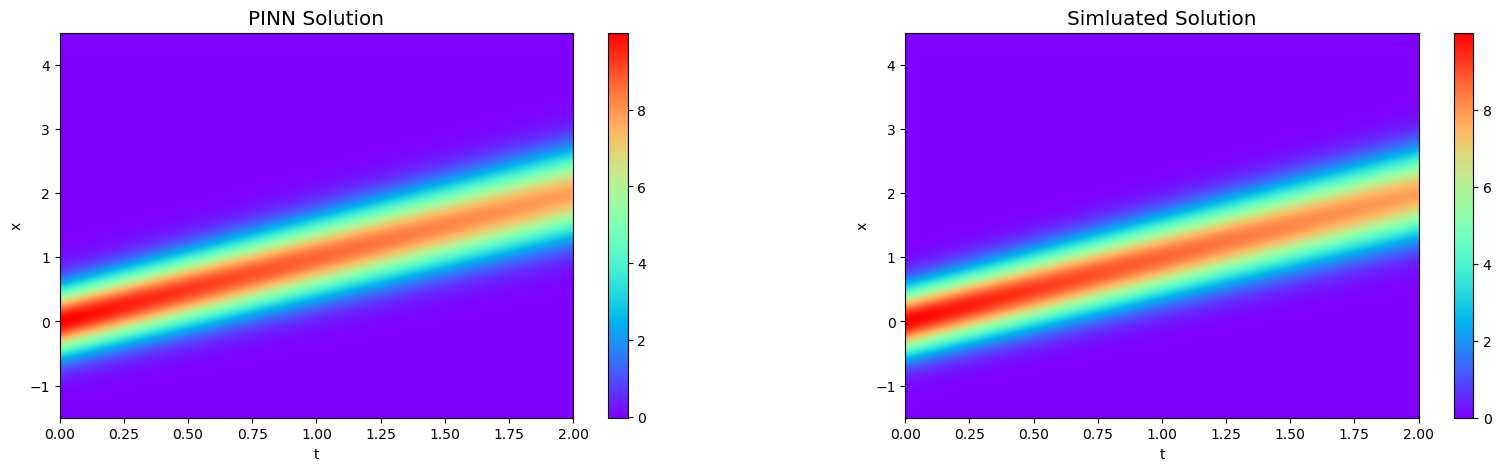

In [7]:
# plot & mse
fig = plt.figure(figsize=(20, 5))
u_viz = (u.reshape(201, 193)).T 
ext = [0 ,2, -1.5, 4.5]     # plot boundary  
ax1 = fig.add_subplot(1,2,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.25); 
plt.colorbar(mesh) 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('PINN Solution', fontsize='x-large'); 

u_true = (batch_y.reshape(201, 193)).T 
ext = [0 ,2, -1.5, 4.5]     # plot boundary    
ax2 = fig.add_subplot(1,2,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.25); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated Solution', fontsize='x-large'); 

jnp.mean((u_viz - u_true)**2)

Write PINN prediction & ground truth to file

In [8]:
#np.save('linear_cma_60s', (u_viz, u_true))